## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии

Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
# to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
images_train.shape

torch.Size([128, 1, 28, 28])

In [5]:
labels_train.shape

torch.Size([128])

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

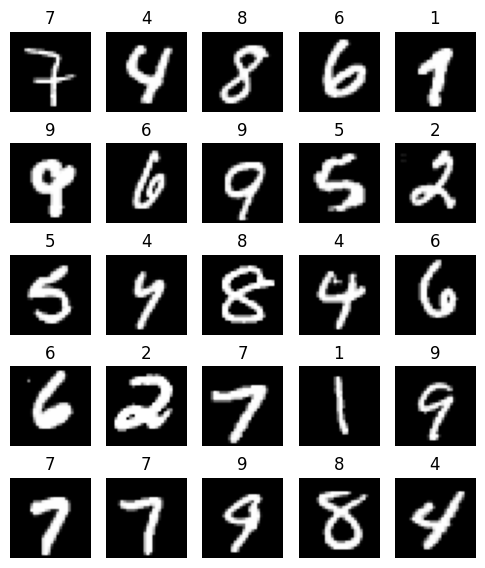

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    
    print(layer)
#     for key, val in layer.state_dict().items():
#         print(f"{key}")
#     print(f"{bias=}")
    
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

Linear(in_features=784, out_features=10, bias=True)


In [9]:
sizes = [28 * 28] + [500] * 10 + [10]
print(sizes, f"{len(sizes)=}")
print(sizes[1:])
for size_input, size_output in zip(sizes, sizes[1:]):
    print(size_input, size_output)

[784, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 10] len(sizes)=12
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 10]
784 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 10


In [10]:
sizes = [28 * 28] + [500] * 10 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)


# init_func = normal
init_func = xavier
# init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean=0.0, std=init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    layers.append(nn.Tanh())
#     layers.append(nn.Sigmoid())
#     layers.append(nn.ReLU())

del layers[-1]

Linear(in_features=784, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=500, bias=True)
Linear(in_features=500, out_features=10, bias=True)


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [11]:
#пример:
network = nn.Sequential(*layers)
n_objects = 128
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9891889095306396
forward 0.6477484107017517
forward 0.48950251936912537
forward 0.4077816307544708
forward 0.3570324778556824
forward 0.3197421729564667
forward 0.2931046485900879
forward 0.27540621161460876
forward 0.25435537099838257
forward 0.240614116191864
forward 0.22778575122356415
backward 0.023524144664406776
backward 0.02003505267202854
backward 0.018928872421383858
backward 0.018780643120408058
backward 0.017811670899391174
backward 0.016188640147447586
backward 0.014597272500395775
backward 0.01278019417077303
backward 0.010699188336730003
backward 0.00835555698722601
backward 0.004983557388186455


/home/sklaa00/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [12]:
sizes = [28 * 28] + [500] * 10 + [10]
activate = nn.Tanh()

# nn.Sigmoid()
# nn.ReLU()

def get_init_network(init_layer, activate=activate, sizes=sizes):
    layers = []

    for size_input, size_output in zip(sizes, sizes[1:]):

        layer = nn.Linear(size_input, size_output)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer)

        layers.append(layer)
        layers.append(activate)

    del layers[-1]
    
    return nn.Sequential(*layers)

In [13]:
loss_fn = torch.nn.NLLLoss()

def show_hooks(network, images_train=images_train, labels_train=labels_train, loss_fn=loss_fn):

    n_objects = 128
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data

    activations = network(X)
    optimizer = torch.optim.Adam(layer.parameters(), lr=1e-4)
    print(layer)
    loss = loss_fn(activations, y)
    
    loss.backward()

In [14]:
def xavier_uniform(layer, mean=0.0, std=1.0):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6) / np.sqrt(weight.size()[1] + weight.size()[0])
    weight.uniform_(-r, r)
    
def he_normal(layer, mean=0.0, std=1.0):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()

    d = np.sqrt(2 / weight.size()[1])
    weight.normal_(mean=mean, std=d)

In [15]:
network_xavier_tanh = get_init_network(xavier_uniform)
show_hooks(network_xavier_tanh)

forward 0.9891889095306396
forward 0.644731342792511
forward 0.49085474014282227
forward 0.41462644934654236
forward 0.36728331446647644
forward 0.32487189769744873
forward 0.29528120160102844
forward 0.27414536476135254
forward 0.25952643156051636
forward 0.24794158339500427
forward 0.2324882447719574
Linear(in_features=500, out_features=10, bias=True)
backward 0.023524144664406776
backward 0.018573543056845665
backward 0.01861702837049961
backward 0.01743340864777565
backward 0.017442001029849052
backward 0.015596676617860794
backward 0.0132775092497468
backward 0.011946268379688263
backward 0.009968201629817486
backward 0.007458152249455452
backward 0.004617198836058378


In [16]:
network_he_tanh = get_init_network(he_normal)
show_hooks(network_he_tanh)

forward 0.9891889095306396
forward 0.7136027216911316
forward 0.6317562460899353
forward 0.5980813503265381
forward 0.5769876837730408
forward 0.5685794353485107
forward 0.5611080527305603
forward 0.5612041354179382
forward 0.5592852234840393
forward 0.5591390132904053
forward 0.5530098080635071
Linear(in_features=500, out_features=10, bias=True)
backward 0.023524144664406776
backward 0.01419889647513628
backward 0.013898140750825405
backward 0.013478103093802929
backward 0.01365332119166851
backward 0.013005811721086502
backward 0.012984604574739933
backward 0.013706530444324017
backward 0.012819990515708923
backward 0.012219528667628765
backward 0.009057492949068546


In [17]:
# relu + he
network_he_relu = get_init_network(he_normal, activate=nn.ReLU())
show_hooks(network_he_relu)

forward 0.9891889095306396
forward 0.7889097332954407
forward 0.8341129422187805
forward 0.8172966241836548
forward 0.7978714108467102
forward 0.8201360702514648
forward 0.8181616067886353
forward 0.8418384194374084
forward 0.8322676420211792
forward 0.796222448348999
forward 0.7898852825164795
Linear(in_features=500, out_features=10, bias=True)
backward 0.023524144664406776
backward 0.013701445423066616
backward 0.012733831070363522
backward 0.011407733894884586
backward 0.010319794528186321
backward 0.00866650603711605
backward 0.007897828705608845
backward 0.007207720540463924
backward 0.0065252217464149
backward 0.0059209768660366535
backward 0.005519508384168148


In [18]:
# relu + xavier
network_xavier_relu = get_init_network(xavier_uniform, activate=nn.ReLU())
show_hooks(network_xavier_tanh)

forward 0.9891889095306396
forward 0.644731342792511
forward 0.49085474014282227
forward 0.41462644934654236
forward 0.36728331446647644
forward 0.32487189769744873
forward 0.29528120160102844
forward 0.27414536476135254
forward 0.25952643156051636
forward 0.24794158339500427
forward 0.2324882447719574
Linear(in_features=500, out_features=10, bias=True)
backward 0.023524144664406776
backward 0.018573543056845665
backward 0.01861702837049961
backward 0.01743340864777565
backward 0.017442001029849052
backward 0.015596676617860794
backward 0.0132775092497468
backward 0.011946268379688263
backward 0.009968201629817486
backward 0.007458152249455452
backward 0.004617198836058378


<i> 1.4 Сделайте выводы по первой части </i>

При различных методах первичной инициализации весов и байса алгоритмы показывают различную скорость сходимости (можно судить по величине градиета: чем меньше, тем ближе к минимуму). Также применения различных функций активации может улучшить сходимость. Xavier более замысловатый, показал лучший результат.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [19]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [20]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [21]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

In [22]:
torch.cuda.is_available()

False

In [22]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# %%time

# #dropout
# from train_utils import train

# network = TestNetwork(nn.Sequential(*layers))

# train(network, train_loader, test_loader, 10, 0.001, device='cuda')

In [ ]:
# %%time

# #dropconnect
# from train_utils import train

# network = TestNetwork(nn.Sequential(*layers))

# train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [ ]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = ##### YOUR CODE HERE #####
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [ ]:
##### YOUR CODE HERE #####

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: